In [3]:
# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import esm
from tqdm import tqdm
import pickle

import sys
sys.path.append('./../../src/')

from utils import *
from TDPredictor_CNN import *

In [6]:
# load full TD dataframe
TD_full_df = pd.read_csv('./../../data/TD/processed_data//TD_full.csv',index_col=0)
TD_full_df

,HLA_full,HLA,MFI_ratio,SD,Source,ID,Sequence,length
0,HLA-A*01:01,A*01:01,32.11,13.77,Bashirova,HLA:HLA00001,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,365
1,HLA-A*01:02,A*01:02,109.86,35.04,Bashirova,HLA:HLA00002,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFSTSVSRPGSGEPRF...,365
2,HLA-A*02:01,A*02:01,2.02,0.22,Bashirova,HLA:HLA00005,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,365
3,HLA-A*02:02,A*02:02,1.45,0.16,Bashirova,HLA:HLA00007,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,365
4,HLA-A*02:05,A*02:05,1.49,0.12,Bashirova,HLA:HLA00010,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,365
...,...,...,...,...,...,...,...,...
92,HLA-C*16:01,C*16:01,5.98,1.33,Bashirova,HLA:HLA00475,MRVMAPRTLILLLSGALALTETWACSHSMRYFYTAVSRPGRGEPRF...,366
93,HLA-C*17:01,C*17:01,2.92,0.98,Bashirova,HLA:HLA04311,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,372
94,HLA-C*17:03,C*17:03,3.63,1.29,Bashirova,HLA:HLA00993,MRVMAPQALLLLLSGALALIETWTGSHSMRYFYTAVSRPGRGEPRF...,372
95,HLA-C*18:01,C*18:01,2.76,0.80,Bashirova,HLA:HLA00483,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...,366


## MFI ratio threshold options
1. Median: Median is 3.61 but A*02:01 which has Tapasin dependency has MFI ratio of 2 (see Barber et al)
2. Threshold=2.0 There are only 18 negative classes below MFI ratio 2
3. Treat as regression? (SHould be fine)



A*02:01 Tapasin dependency:
1. Thuring et al. (https://www.nature.com/articles/bjc2015297), 
2. Barber et al https://onlinelibrary.wiley.com/doi/10.1034/j.1399-0039.2001.580604.x, 
3. Roder et al https://www.sciencedirect.com/science/article/pii/S0021925819491205?via%3Dihub

In [64]:
aa_str = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'
aa_dict = {i:idx for idx,i in enumerate(aa_str)}
aa_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 '-': 26}

In [65]:
# make positions into  columns
new_cols = TD_full_df['Sequence'].str.split('',expand=True)

# get X 
X = pd.concat([TD_full_df[['HLA','MFI_ratio']], new_cols], axis=1).fillna('-').replace('','-').drop([0,373,'HLA','MFI_ratio'],axis=1)
X = X.apply(lambda col: col.map(aa_dict))

# get y
y = pd.concat([TD_full_df[['HLA','MFI_ratio']], new_cols], axis=1)['MFI_ratio'].to_numpy()


In [66]:
mse_rf_seq = []
for i in range(5):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest regressor
    RF = RandomForestRegressor(n_estimators=50, max_depth=30, random_state=i)
    RF.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = RF.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    
    mse_rf_seq = mse_rf_seq + [mse]
    
    

Mean Squared Error: 303.1018472339998
Mean Squared Error: 371.78619787600013
Mean Squared Error: 361.8501431320002
Mean Squared Error: 442.8280688000001
Mean Squared Error: 297.60216598600005


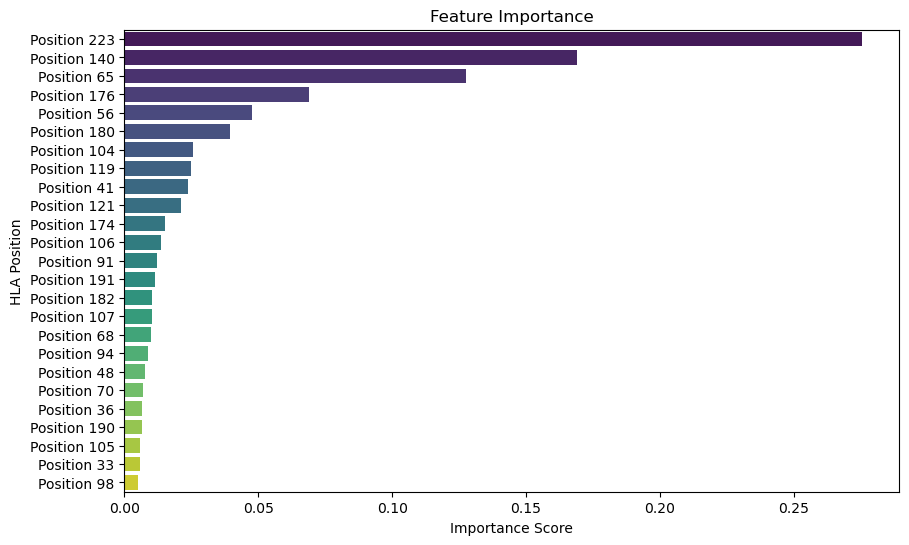

In [6]:
# Get feature importances
feature_importances = RF.feature_importances_

# Create DataFrame with feature names and importance scores
feature_names = [f'Position {i+1}' for i in range(len(feature_importances))]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.iloc[:25], palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('HLA Position')
plt.title('Feature Importance')
plt.show()


# With ESM2

From https://github.com/facebookresearch/esm

In [3]:
TD_full_df

,HLA_full,HLA,MFI_ratio,SD,Source,ID,Sequence,length
0,HLA-A*01:01,A*01:01,32.11,13.77,Bashirova,HLA:HLA00001,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,365
1,HLA-A*01:02,A*01:02,109.86,35.04,Bashirova,HLA:HLA00002,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFSTSVSRPGSGEPRF...,365
2,HLA-A*02:01,A*02:01,2.02,0.22,Bashirova,HLA:HLA00005,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,365
3,HLA-A*02:02,A*02:02,1.45,0.16,Bashirova,HLA:HLA00007,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,365
4,HLA-A*02:05,A*02:05,1.49,0.12,Bashirova,HLA:HLA00010,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,365
...,...,...,...,...,...,...,...,...
92,HLA-C*16:01,C*16:01,5.98,1.33,Bashirova,HLA:HLA00475,MRVMAPRTLILLLSGALALTETWACSHSMRYFYTAVSRPGRGEPRF...,366
93,HLA-C*17:01,C*17:01,2.92,0.98,Bashirova,HLA:HLA04311,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,372
94,HLA-C*17:03,C*17:03,3.63,1.29,Bashirova,HLA:HLA00993,MRVMAPQALLLLLSGALALIETWTGSHSMRYFYTAVSRPGRGEPRF...,372
95,HLA-C*18:01,C*18:01,2.76,0.80,Bashirova,HLA:HLA00483,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...,366


In [11]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data 
data = [(v['HLA_full'], v['Sequence']) for k,v in TD_full_df[['HLA_full','Sequence']].T.to_dict().items()]
batch_labels, batch_strs, batch_tokens = batch_converter(data)


In [12]:
# embedding
embedding_dict = {} 
for idx, batch_token in tqdm(enumerate(batch_tokens)):
    embedding_dict[batch_labels[idx]] = get_esm_embedding(model, batch_tokens[idx:idx+1], mean=True)
    
# save embeddings
with open('./Data/processed_data/allele_esm1b.pkl','wb') as f:
    pickle.dump(embedding_dict, f)
    
embedding_dict

97it [09:44,  6.03s/it]


{'HLA-A*01:01': tensor([[-0.0175, -0.0270, -0.0234,  ..., -0.0569,  0.0393,  0.0693]]),
 'HLA-A*01:02': tensor([[-0.0160, -0.0260, -0.0257,  ..., -0.0601,  0.0384,  0.0687]]),
 'HLA-A*02:01': tensor([[-0.0016, -0.0314, -0.0237,  ..., -0.0590,  0.0384,  0.0710]]),
 'HLA-A*02:02': tensor([[-0.0020, -0.0312, -0.0239,  ..., -0.0593,  0.0410,  0.0700]]),
 'HLA-A*02:05': tensor([[-0.0019, -0.0322, -0.0257,  ..., -0.0591,  0.0420,  0.0692]]),
 'HLA-A*03:01': tensor([[-0.0115, -0.0268, -0.0182,  ..., -0.0563,  0.0385,  0.0768]]),
 'HLA-A*11:01': tensor([[-0.0127, -0.0270, -0.0204,  ..., -0.0585,  0.0396,  0.0772]]),
 'HLA-A*11:02': tensor([[-0.0161, -0.0275, -0.0226,  ..., -0.0567,  0.0384,  0.0760]]),
 'HLA-A*23:01': tensor([[-0.0117, -0.0215, -0.0158,  ..., -0.0574,  0.0455,  0.0724]]),
 'HLA-A*24:02': tensor([[-0.0135, -0.0240, -0.0174,  ..., -0.0590,  0.0413,  0.0787]]),
 'HLA-A*25:01': tensor([[-0.0043, -0.0157, -0.0223,  ..., -0.0545,  0.0368,  0.0696]]),
 'HLA-A*26:01': tensor([[-0.0055